# NLP Disaster Tweet Classification using RNN
## Overview
Being able to classify written text has large implications for the world. This project specifically tries to identify disasters from tweets. The applicaiton could be better new reporting of events happening now. Machine learning presents a huge opportunity to make the dissemination of import information more accessible to the world.

In this notebook we will attempt to develop an LSTM model to classify tweets.

The requirements for completion of this project are listed below:

## Brief description of the problem and data
Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
* Model Architecture
* Results and Analysis
* Conclusion
* Setup

In the following lines of code I import the packages necessary to perform the following functions:
* Data Inspection
* Data Visualization
* Model Creation
* Model Evaluation



In [19]:
#! pip install tensorflow --upgrade
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import re
import keras_tuner as kt
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.backend import clear_session
from keras.datasets import mnist
from keras.layers import Conv2D
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.metrics import MeanAbsoluteError
from keras.losses import BinaryCrossentropy
from keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

nltk.download('omw-1.4')
print(tf.__version__)

2.6.4


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Data Import and Description
The below group of code imports the training and test data.

The training data is very simple with three main columns. The first column is the id of the tweet. The second column is the tweet and the third column contains the label of whether the tweet is describing a disaster.

By investigating the first 5 rows we get a good sample of the full dataset.

The full data set contains 7613 tweets. 4342 are not related to disasters and 3271 are related to disasters.

By running a Pandas Profile we see that there is no missing text data.


In [20]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [21]:
print(len(train_df))

7613


In [22]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [23]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

In [24]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

## Data Cleansing

After inpsection it is now time to cleanse our data which is very important in NLP projects.

I utilize 3 main strategies to cleanse the text.

1. I remove stopwords which have been printed directly below
2. During tokenization I lower case all words
3. During tokenization I remove all special characters


In [25]:
stop_words=stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [26]:
def make_txt(text):
    tokens=word_tokenize(text)
    # remove stopwords and lemma
    lemmatizer = WordNetLemmatizer()
    
    filters=[lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(filters)

In [27]:
train_df["clean_text"]=train_df.text.apply(make_txt)
test_df["clean_text"]=test_df.text.apply(make_txt)

In [28]:
report = ProfileReport(train_df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Model Architecture
### Data Preperation
The below code snippets modifies the trainng, validation, and test sets to be used in tensorflow.

The following steps were taken:

1. I first tokenize the tweets. During tokenization I clean the data and choose the top number of words to include in the model. I chose to use 1000 of the top words words.
2. I output the total length of the vocabulary which is 21697 words. Only of which 1000 were tokenized and will be used in the model
3. Next I sequence the tokens. The output is a matrix with the index of each word in the tweet.
4. The longest tweet at this point is 23 words.
5. I then pad the index with -1 so that all tweets are now 23 words. 

In [29]:
tokenizer=Tokenizer(
    num_words=1000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',)
tokenizer.fit_on_texts(train_df.clean_text)

In [30]:
# Get our training data word index
vocab=len(tokenizer.word_index)
vocab

21697

In [31]:
df_seq=tokenizer.texts_to_sequences(train_df.clean_text)
df_seq_test=tokenizer.texts_to_sequences(test_df.clean_text)
df_seq[:10]

[[646, 616, 227, 96, 20],
 [140, 11, 203, 752],
 [133, 524, 6, 372, 108, 216, 524, 373],
 [785, 21, 110, 216, 373, 52],
 [179, 44, 243, 237, 110, 134],
 [238, 52, 669, 812, 525, 996, 374, 11, 110],
 [66, 25, 813, 207, 204, 786, 232, 506, 997, 192],
 [4, 14, 186, 4, 59, 11],
 [165, 5, 26, 216, 40, 814, 506],
 [4, 14, 324, 217, 192]]

In [32]:
max_len=max([len(i) for i in df_seq])
max_len

23

In [33]:
df_padded=pad_sequences(df_seq,maxlen=max_len, value=-1, padding='post',truncating='post')
df_padded_test=pad_sequences(df_seq_test,maxlen=max_len, value=-1, padding='post',truncating='post')
df_padded

array([[646, 616, 227, ...,  -1,  -1,  -1],
       [140,  11, 203, ...,  -1,  -1,  -1],
       [133, 524,   6, ...,  -1,  -1,  -1],
       ...,
       [663,  72, 520, ...,  -1,  -1,  -1],
       [ 30, 537, 321, ...,  -1,  -1,  -1],
       [  7, 171, 111, ...,  -1,  -1,  -1]], dtype=int32)

In [34]:
X=np.array(df_padded)
y=train_df.target.values

## Model Preperation
The below is where I generate the model. The following conseriderations were taken:

1. First choice is using Accuracy as the model metric to determine the accuracy.
2. I used word embedding to translate the model form simply a indexed lookup to each word to a dense representation of parameters
3. The next choice was using a two LSTM layers. The first has a set number of units and returns the full sequence. The second layer has a built in optimizer to detmerine the number of units.
4. The next choice was to add a dropou layer. This is also optimized
5. I add a dense layer and the activation function is also optimized
6. Finally, during compilation I chose to optimize the learning rate in the Adam optimizer

The optimizer being uses is the keras_tuner package. It tries to maximize val accuracy.

The optimizer runs 100s of times before settling on the best parameters.


In [35]:
def build_model_1(hp):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab, output_dim=hp.Int('embedding_ouput_dim',min_value=10,max_value=30,step=10), input_length=max_len),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(hp.Int('input_unit',min_value=10,max_value=50,step=10),return_sequences=True)),
        tf.keras.layers.Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.1,step=0.025)),
        tf.keras.layers.Dense(1,activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu'))
    ])


    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate',min_value=0,max_value=0.01,step=0.001)),
                  metrics=['accuracy'])
    model.summary()
    return model

In [36]:
    epochs_standard = 100
    tuner = kt.Hyperband(
        hypermodel=build_model_1,
        objective=kt.Objective(name="val_accuracy",direction="max"),
        max_epochs=epochs_standard,
        factor=3,
        hyperband_iterations=1,
        overwrite=False
    )
    stop_early = EarlyStopping(monitor='val_accuracy', patience=10)

    tuner.search(X,y, epochs=epochs_standard, validation_split=0.2, callbacks=[stop_early])

Trial 254 Complete [00h 00m 21s]
val_accuracy: 0.8017928600311279

Best val_accuracy So Far: 0.811755895614624
Total elapsed time: 00h 51m 12s


## Model Application

Once the optimal hyperparameters have been identified, the best parameters are applied to a hypermodel.

Once the first hypermodel is trained a second is built using the best epoch of that model. 

After the final model is built the summary and a plot of the model is given to ensure that it is expected. 

The final metics are then plot based upon the final model 

In [37]:
# # Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=3)[0]

In [38]:
print(f"""
The hyperparameter search is complete. The optimal drop out rate of layers for the optimizer
is {best_hps.get('Dropout_rate')}. The optimal dense_activation is {best_hps.get('dense_activation')}
""")


The hyperparameter search is complete. The optimal drop out rate of layers for the optimizer
is 0.07500000000000001. The optimal dense_activation is sigmoid



In [39]:
# Build the model with the optimal hyperparameters and train it on the data for x epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X,y, epochs=epochs_standard, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 23, 20)            433940    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 23, 60)            9360      
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 60)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 23, 1)             61        
Total params: 443,361
Trainable params: 443,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
191/191 [==============================] - 5s 10ms/step - loss: 0.5283 - accuracy: 0.7448 - val_loss: 0.4489 - val_accuracy: 0.8066
Epoch 2/100
191/191 [==============================] - 1s 7ms/step - loss: 0.4358 - accuracy: 0.8153 -

In [40]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 1


In [41]:
hypermodel = tuner.hypermodel.build(best_hps)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 23, 20)            433940    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 23, 60)            9360      
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 60)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 23, 1)             61        
Total params: 443,361
Trainable params: 443,361
Non-trainable params: 0
_________________________________________________________________


215/215 [==============================] - 4s 9ms/step - loss: 0.5237 - accuracy: 0.7480 - val_loss: 0.4553 - val_accuracy: 0.8034
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 23, 20)            433940    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 23, 60)            9360      
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 60)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 23, 1)             61        
Total params: 443,361
Trainable params: 443,361
Non-trainable params: 0
_________________________________________________________________


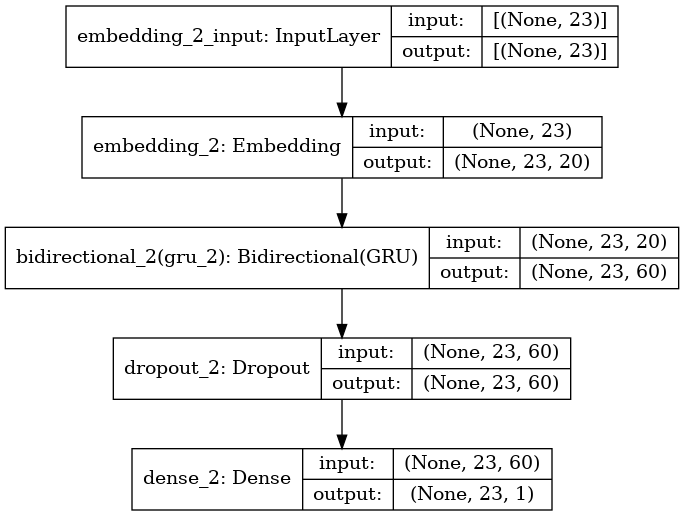

In [42]:
# Retrain the model
finalhistory = hypermodel.fit(X,y,epochs=best_epoch, validation_split=0.1)
hypermodel.summary()
plot_model(hypermodel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [43]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [44]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(finalhistory, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(finalhistory, 'loss')

## Results and Analysis

The model does an ok job at learning. It feels like the model overfits which could be addressed in the model design.

From the analysis done the best epoch of the final model is the first meaning the model could be tweaked to do a better job at learning however I did notice serious overfitting when learning rates were decreased.

In [45]:
predict = hypermodel.predict(df_padded_test)
predict

array([[[0.64911854],
        [0.63644433],
        [0.61187035],
        ...,
        [0.5427868 ],
        [0.5504276 ],
        [0.56014585]],

       [[0.7003684 ],
        [0.7398292 ],
        [0.68309206],
        ...,
        [0.6656554 ],
        [0.6728036 ],
        [0.68169117]],

       [[0.86272836],
        [0.83647573],
        [0.8384768 ],
        ...,
        [0.7490458 ],
        [0.7552895 ],
        [0.76294833]],

       ...,

       [[0.7355371 ],
        [0.7001534 ],
        [0.7258436 ],
        ...,
        [0.6017099 ],
        [0.60923207],
        [0.6186846 ]],

       [[0.8168431 ],
        [0.79128635],
        [0.74945027],
        ...,
        [0.71832377],
        [0.7249812 ],
        [0.7331817 ]],

       [[0.22879803],
        [0.22211093],
        [0.20066631],
        ...,
        [0.19726038],
        [0.20822692],
        [0.22124875]]], dtype=float32)

In [46]:
predict = np.around(predict)
predict

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)

In [47]:
predArray = []
for each in predict:
    j = each.mean()
    j = np.around(j)
    if j > 1:
        j = 1
    predArray.append(j)
np.array(predArray,dtype=int)

array([1, 1, 1, ..., 1, 1, 0])

In [48]:
len(predict[0])

23

In [49]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [50]:
len(sample_submission)

3263

In [51]:
submit = pd.DataFrame({
        "id": sample_submission["id"],
        "target":predArray
    })

In [52]:
submit.target.value_counts()

0.0    2348
1.0     915
Name: target, dtype: int64

In [53]:
submit.head()
submit = submit.set_index('id')

In [55]:
submit.to_csv("submission.csv", index=True)

## Conclusion
To be able to see the difference that machine learning can make on such an important area of study is extremely empowering.

The major improvement to this project that I would make is to keep refining the model. I believe it is overfitting the data provided.

Futher I think more time spent in feature selection would have greatly improved the score. 

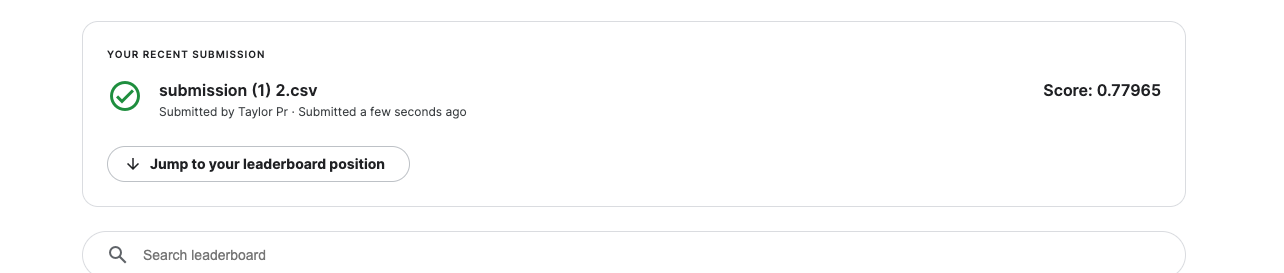